# Packages

In [138]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import Util as ut
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from functools import partial

# Reading data

## Parameters

In [139]:
dir_data = '/home/viannazv/notebooks/Data/'
name_mask = 'mask_eNATL60MEDWEST_3.6.nc'
name_coord = 'coordinates_eNATL60MEDWEST.nc'
name_ssh = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_sossheig.nc'
name_u = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_sozocrtx.nc'
name_v = 'eNATL60MEDWEST-BLB002_y2009m07d01.1h_somecrty.nc'

## Opening data

In [140]:
ds_coord = xr.open_dataset(dir_data+name_coord)
lon = ds_coord.nav_lon.values
lat = ds_coord.nav_lat.values

ds_mask = xr.open_dataset(dir_data+name_mask)
mask_ssh = ds_mask.tmask[0,0].values
mask_u = ds_mask.umask[0,0].values
mask_v = ds_mask.vmask[0,0].values

ds_ssh = xr.open_dataset(dir_data+name_ssh)
#print(ds_ssh)
lon_ssh = ds_ssh.nav_lon.values
lat_ssh = ds_ssh.nav_lat.values
ssh = ds_ssh.sossheig[0].values

ds_u = xr.open_dataset(dir_data+name_u)
#print(ds_u)
lon_u = ds_u.nav_lon.values
lat_u = ds_u.nav_lat.values
uvel = ds_u.sozocrtx[0].values

ds_v = xr.open_dataset(dir_data+name_v)
#print(ds_v)
lon_v = ds_v.nav_lon.values
lat_v = ds_v.nav_lat.values
vvel = ds_v.somecrty[0].values

## Ploting the data

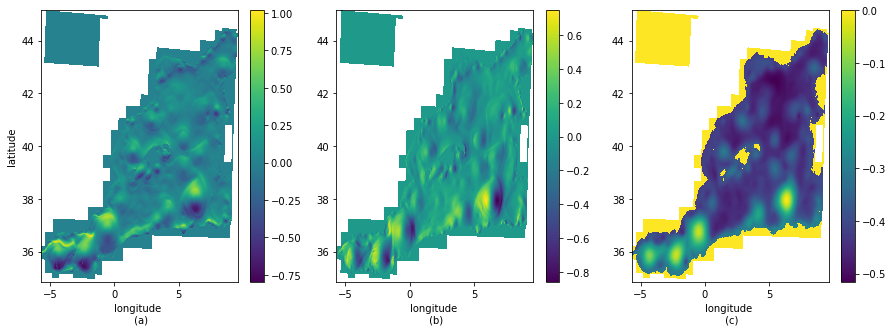

In [141]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon, lat, uvel,shading='auto')
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon, lat,vvel,shading='auto')
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon, lat,ssh,shading='auto')
plt.colorbar(im,ax=ax3)
plt.show()

 ## Spliting the data for the geostrophy

In [142]:
"Spliting the data for the geostrophy"

# x1 =180
# x2 = -480
# y1 = 500
# y2 = -100

# Reduced grid for testing
x1 =180
x2 = -615
y1 = 500
y2 = -375

ssh = ssh[x1-1 : x2+1, y1-1 : y2+1]
lat_ssh = lat_ssh[x1-1 : x2+1, y1-1 : y2+1]
lon_ssh = lon_ssh[x1-1 : x2+1, y1-1 : y2+1]

uvel = uvel[x1 : x2, y1-1 : y2]
lat_u = lat_u[x1 : x2, y1-1 : y2]
lon_u = lon_u[x1 : x2, y1-1 : y2]

vvel = vvel[x1-1 : x2, y1 : y2]
lat_v = lat_v[x1-1 : x2, y1 : y2]
lon_v = lon_v[x1-1 : x2, y1 : y2]

## Ploting the split data

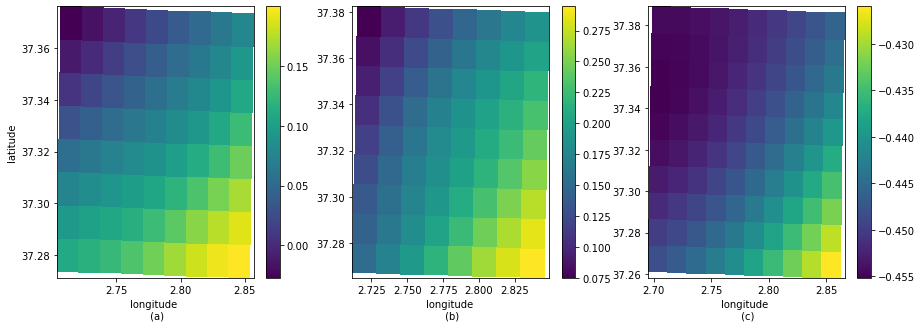

In [143]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, uvel,shading='auto')
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_v,lat_v,vvel,shading='auto')
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon_ssh, lat_ssh,ssh,shading='auto')
plt.colorbar(im,ax=ax3)
plt.show()

## Plotting the C-Grid"

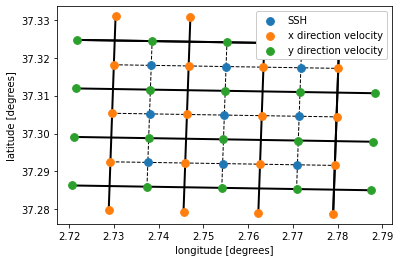

In [144]:
fig = ut.PlotGrid(lon_ssh, lat_ssh, lon_u, lat_u, lon_v, lat_v)

# Input data

In [145]:
gravity = 9.81 #[m/s2]
coriolis_factor_ssh = 2 * 7.2722e-05 * np.sin(lat_ssh * np.pi / 180)
coriolis_factor_u = 2 * 7.2722e-05 * np.sin(lat_u * np.pi / 180)
coriolis_factor_v = 2 * 7.2722e-05 * np.sin(lat_v * np.pi / 180)

# Geostrophic  balance

## Gradient of the SSH

In [146]:
grad_ssh_x, grad_ssh_y = ut.compute_gradient(ssh, lon_ssh, lat_ssh)

## Interpolation of the data (moving the grad into the u and v position)

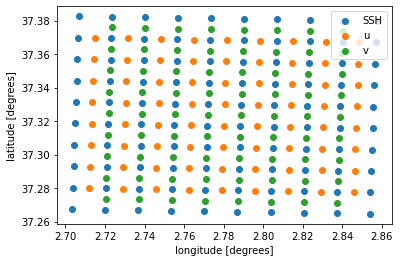

In [147]:
grad_ssh_y = ut.interpolate_y(grad_ssh_y)
grad_ssh_y = ut.interpolate_x(grad_ssh_y)

grad_ssh_x = ut.interpolate_x(grad_ssh_x)
grad_ssh_x = ut.interpolate_y(grad_ssh_x)

plt.figure()
plt.scatter(lon_ssh, lat_ssh, label='SSH', zorder=2)
plt.scatter(lon_u, lat_u,label='u', zorder=1)
plt.scatter(lon_v, lat_v, label='v',zorder=1)
# plt.xlim(2.7,2.775)
# plt.ylim(37.265,37.32)
plt.xlabel('longitude [degrees]')
plt.ylabel('latitude [degrees]')
plt.legend(loc=1)
plt.show()

## Geostrophic velocities

In [148]:
u_geos = - gravity * grad_ssh_y / coriolis_factor_u
v_geos =   gravity * grad_ssh_x / coriolis_factor_v

## Ploting the u_geos and v_geos

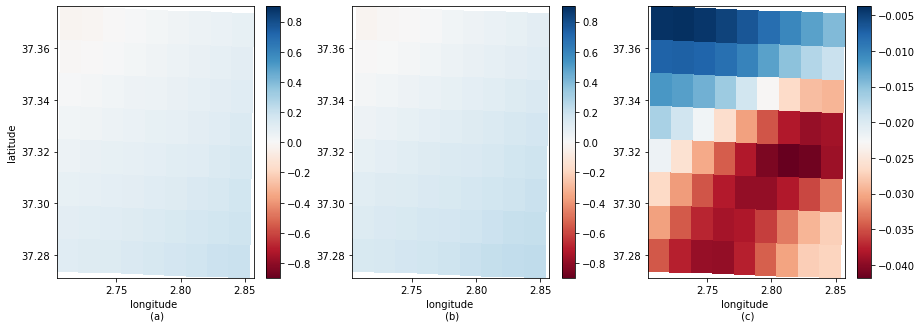

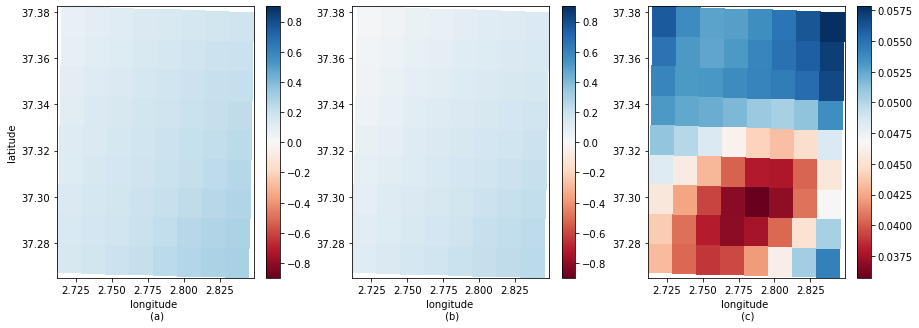

In [149]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_u, lat_u, uvel, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_u,lat_u,u_geos, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon_u, lat_u,uvel-u_geos, cmap='RdBu',shading='auto')
plt.colorbar(im,ax=ax3)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.set_xlabel('longitude \n (a)')
ax2.set_xlabel('longitude \n (b)')
ax3.set_xlabel('longitude \n (c)')
ax1.set_ylabel('latitude')
im = ax1.pcolormesh(lon_v, lat_v, vvel, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax1)
im = ax2.pcolormesh(lon_v,lat_v,v_geos, cmap='RdBu',shading='auto',vmin=-0.9, vmax=0.9)
plt.colorbar(im,ax=ax2)
im = ax3.pcolormesh(lon_v, lat_v,vvel-v_geos, cmap='RdBu',shading='auto')
plt.colorbar(im,ax=ax3)

# Cyclogeostrophic balance

## Computing the advection term

In [150]:
# testing the advection functions
adv_u = ut.compute_advection_u(u_geos, v_geos, lon_u, lat_u)
adv_v = ut.compute_advection_v(u_geos, v_geos, lon_v, lat_v)

## Resize of the grid

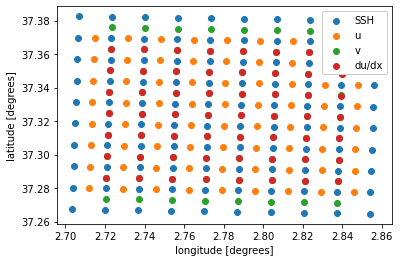

In [151]:
# =============================================================================
# Due to the interpolation of the advection term, the grid has to be reduced.
# =============================================================================

# =============================================================================
# Ploting the advection u in the mesh (v point)
# =============================================================================

dudx_lon = ut.interpolate_x(lon_u)
dudx_lat = ut.interpolate_x(lat_u)

dudx_lon = ut.interpolate_y(dudx_lon)
dudx_lat = ut.interpolate_y(dudx_lat)

dudy_lon = ut.interpolate_y(lon_u)
dudy_lat = ut.interpolate_y(lat_u)

dudy_lon = ut.interpolate_x(dudy_lon)
dudy_lat = ut.interpolate_x(dudy_lat)

u_lon_int = ut.interpolate_x(lon_u)
u_lat_int = ut.interpolate_x(lat_u)

u_lon_int = ut.interpolate_y(u_lon_int)
u_lat_int = ut.interpolate_y(u_lat_int)

plt.figure()
plt.scatter(lon_ssh, lat_ssh, label='SSH', zorder=2)
plt.scatter(lon_u, lat_u,label='u', zorder=1)
plt.scatter(lon_v, lat_v, label='v',zorder=1)
plt.scatter(dudx_lon, dudx_lat, label='du/dx',zorder=4)
# plt.scatter(dudy_lon, dudy_lat, label='du/dy',zorder=3,c ='purple')
# plt.scatter(u_lon_int, u_lat_int, label='u_int',zorder=3, c ='cyan')
# plt.xlim(2.715,2.8)
# plt.ylim(37.275,37.34)
plt.xlabel('longitude [degrees]')
plt.ylabel('latitude [degrees]')
plt.legend(loc=1,framealpha =1)
plt.show()

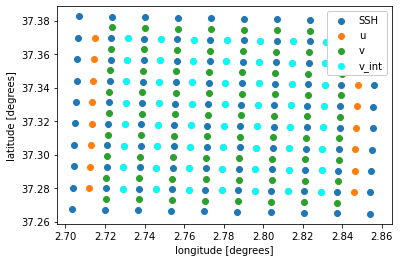

In [152]:
# =============================================================================
# Ploting the advection v in the mesh (u point)
# =============================================================================

dvdx_lon = ut.interpolate_x(lon_v)
dvdx_lat = ut.interpolate_x(lat_v)

dvdx_lon = ut.interpolate_y(dvdx_lon)
dvdx_lat = ut.interpolate_y(dvdx_lat)

dvdy_lon = ut.interpolate_y(lon_v)
dvdy_lat = ut.interpolate_y(lat_v)

dvdy_lon = ut.interpolate_x(dvdy_lon)
dvdy_lat = ut.interpolate_x(dvdy_lat)

v_lon_int = ut.interpolate_x(lon_v)
v_lat_int = ut.interpolate_x(lat_v)

v_lon_int = ut.interpolate_y(v_lon_int)
v_lat_int = ut.interpolate_y(v_lat_int)

plt.figure()
plt.scatter(lon_ssh, lat_ssh, label='SSH', zorder=2)
plt.scatter(lon_u, lat_u,label='u', zorder=1)
plt.scatter(lon_v, lat_v, label='v',zorder=1)
# plt.scatter(dvdx_lon, dvdx_lat, label='dv/dx',zorder=4)
# plt.scatter(dvdy_lon, dvdy_lat, label='dv/dy',zorder=3,c ='purple')
plt.scatter(v_lon_int, v_lat_int, label='v_int',zorder=3, c ='cyan')
# plt.xlim(2.715,2.8)
# plt.ylim(37.275,37.34)
plt.xlabel('longitude [degrees]')
plt.ylabel('latitude [degrees]')
plt.legend(loc=1,framealpha =1)
plt.show()

In [283]:
# lon_ssh = lon_ssh[1:-1,1:-1]
# lat_ssh = lat_ssh[1:-1,1:-1]

# lon_u = lon_u[:,1:-1]
# lat_u = lat_u[ :,1:-1]

# lon_v = lon_v[1:-1,:]
# lat_v = lat_v[1:-1,:]

u_geos_r = u_geos[:,1:-1]
v_geos_r = v_geos[1:-1,:]

coriolis_factor_ssh = coriolis_factor_ssh[1:-1,1:-1]
coriolis_factor_u = coriolis_factor_u[:,1:-1]
coriolis_factor_v = coriolis_factor_v[1:-1,:]

## Defining the cost function

In [276]:
# The use of lambda functions makes it easier to use grad().
J_u = lambda u,v: np.sum(((u[:,1:-1] + ut.compute_advection_v(u, v, lon_v, lat_v)/coriolis_factor_u)*u[:,1:-1] - u_geos_r)**2) 
J_v = lambda u,v: np.sum(((v[1:-1,:] + ut.compute_advection_u(u, v, lon_u, lat_u)/coriolis_factor_v)*v[1:-1,:] - v_geos_r)**2)

In [278]:
# Initial loss
u = u_geos
v = v_geos

J = J_u(u,v) + J_v(u,v)
J

1.4545378022768811

In [280]:
gradJ_u=grad(J_v, argnums=(1))
gradJ_v=grad(J_u,)


In [281]:
from scipy.optimize import minimize
result = minimize(gradJ_u,[u,v])

ValueError: setting an array element with a sequence.